In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
def image_loader(image_name):
    imsize = 512 if torch.cuda.is_available() else 128
    loader = transforms.Compose([transforms.Resize((imsize, imsize)), transforms.ToTensor()])
    image = loader(Image.open(image_name)).unsqueeze(0)
    return image.to(device, torch.float)

def gram_matrix(X):
    a, b, c, d = X.size()  # a=batch size(=1)
                           # b=number of feature maps
                           # (c,d)=dimensions of a f. map (N=c*d)
    N = a * b * c * d
    features = X.view(a * b, c * d) / np.sqrt(N)  # resise F_XL into \hat F_XL
    return torch.mm(features, features.t())

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, X):
        self.loss = F.mse_loss(X, self.target)
        return X

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, X):
        self.loss = F.mse_loss(gram_matrix(X), self.target)
        return X

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [5]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img, content_layers, style_layers):
    cnn = copy.deepcopy(cnn)

    normalization = Normalization(normalization_mean, normalization_std).to(device)
    model = nn.Sequential(normalization)

    content_losses = []
    style_losses = []

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=100,
                       style_weight=1000000, content_weight=1, 
                       content_layers=["conv_4"], style_layers=[f"conv_{i}" for i in range(1, 6)]):
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn, 
        normalization_mean, normalization_std, style_img, content_img, 
        content_layers=content_layers, style_layers=style_layers)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:
        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score
        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

In [6]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [7]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()
print(cnn)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [8]:
content_img = image_loader("dancing.jpg")
style_img = image_loader("picasso.jpg")

unloader = transforms.ToPILImage()  # reconvert into PIL image

cnt_l = list(range(1, 15))
style_l = list(range(1, 15))

cnt_l = [f"conv_{i}" for i in cnt_l]
style_l = [f"conv_{i}" for i in style_l]

# input_img = content_img.clone()
input_img = torch.randn(content_img.data.size(), device=device)


output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, 
                            content_layers=cnt_l, style_layers=style_l, num_steps=1000)

Building the style transfer model..
<ipython-input-4-bada0ef0bc38>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-4-bada0ef0bc38>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)
Optimizing..
run [50]:
Style Loss : 696.608215 Content Loss: 297.646790

run [100]:
Style Loss : 266.826691 Content Loss: 229.860382

run [150]:
Style Loss : 162.081039 Content Loss: 192.153854

run [200]:
Style Loss : 123.287613 Content Loss: 168.654510

run [250]:
Style Loss : 100.015541 Content Loss: 152.275986

run [300]:
Style Loss : 82.603973 Content Loss: 139.935501

run [350]:
Style Loss : 69.9832

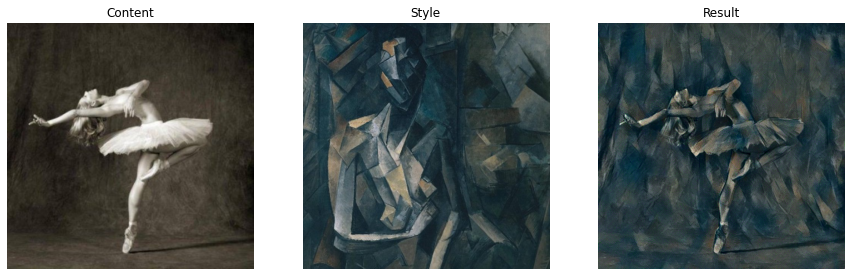

In [9]:
imgs = [(unloader(content_img.cpu().clone().squeeze(0)), "Content"),
        (unloader(style_img.cpu().clone().squeeze(0)), "Style"), 
        (unloader(output.cpu().clone().squeeze(0)), "Result")]

fig, ax = fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for idx, x in enumerate(ax):
    x.axis("off")
    x.imshow(imgs[idx][0])
    x.set_title(imgs[idx][1])
plt.show()

In [10]:
content_img = image_loader("dancing.jpg")
style_img = image_loader("1.jpeg")

unloader = transforms.ToPILImage()  # reconvert into PIL image

cnt_l = list(range(1, 15))
style_l = list(range(1, 15))

cnt_l = [f"conv_{i}" for i in cnt_l]
style_l = [f"conv_{i}" for i in style_l]

input_img = content_img.clone()
# input_img = torch.randn(content_img.data.size(), device=device)

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, 
                            content_layers=cnt_l, style_layers=style_l, num_steps=900)

Building the style transfer model..
<ipython-input-4-bada0ef0bc38>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-4-bada0ef0bc38>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)
Optimizing..
run [50]:
Style Loss : 1285.628662 Content Loss: 523.277161

run [100]:
Style Loss : 693.150757 Content Loss: 515.638000

run [150]:
Style Loss : 218.879288 Content Loss: 512.073486

run [200]:
Style Loss : 122.917542 Content Loss: 492.053741

run [250]:
Style Loss : 93.866371 Content Loss: 476.739227

run [300]:
Style Loss : 73.510170 Content Loss: 469.415314

run [350]:
Style Loss : 58.4171

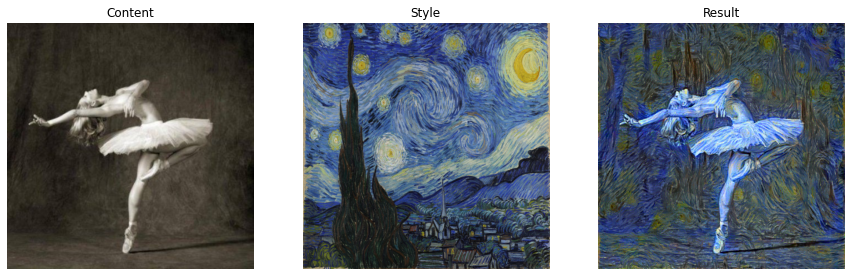

In [11]:
imgs = [(unloader(content_img.cpu().clone().squeeze(0)), "Content"),
        (unloader(style_img.cpu().clone().squeeze(0)), "Style"), 
        (unloader(output.cpu().clone().squeeze(0)), "Result")]

fig, ax = fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for idx, x in enumerate(ax):
    x.axis("off")
    x.imshow(imgs[idx][0])
    x.set_title(imgs[idx][1])
plt.show()

In [41]:
content_img = image_loader("dancing.jpg")
style_img = image_loader("3.jpg")

unloader = transforms.ToPILImage()  # reconvert into PIL image

cnt_l = list(range(1, 15))
style_l = list(range(1, 11))

cnt_l = [f"conv_{i}" for i in cnt_l]
style_l = [f"conv_{i}" for i in style_l]

input_img = content_img.clone()
# input_img = torch.randn(content_img.data.size(), device=device)

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, 
                            content_layers=cnt_l, style_layers=style_l, num_steps=1000)

Building the style transfer model..
<ipython-input-4-bada0ef0bc38>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-4-bada0ef0bc38>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)
Optimizing..
run [50]:
Style Loss : 2786.955566 Content Loss: 694.318481

run [100]:
Style Loss : 1166.399658 Content Loss: 699.122986

run [150]:
Style Loss : 719.352783 Content Loss: 687.717834

run [200]:
Style Loss : 549.679016 Content Loss: 673.322388

run [250]:
Style Loss : 430.908661 Content Loss: 667.394043

run [300]:
Style Loss : 355.526733 Content Loss: 659.854248

run [350]:
Style Loss : 297.

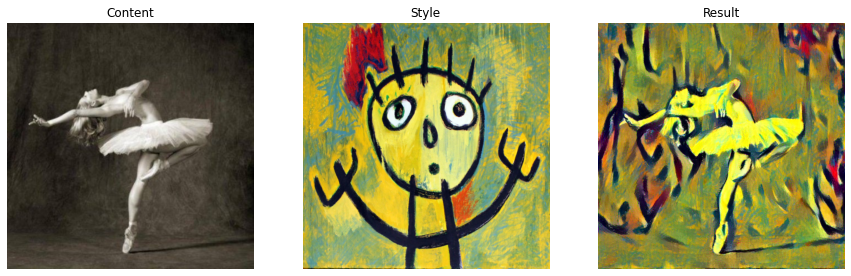

In [42]:
imgs = [(unloader(content_img.cpu().clone().squeeze(0)), "Content"),
        (unloader(style_img.cpu().clone().squeeze(0)), "Style"), 
        (unloader(output.cpu().clone().squeeze(0)), "Result")]

fig, ax = fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for idx, x in enumerate(ax):
    x.axis("off")
    x.imshow(imgs[idx][0])
    x.set_title(imgs[idx][1])
plt.show()